# Assignment: Linear Models
## Do three questions.
### `! git clone https://github.com/ds4e/linearModels`

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
3. Can linear regression be used for classification? Explain why, or why not.
4. What are signs that your linear model is over-fitting?
5. Clearly explain multi-colinearity using the two-stage least squares technique.
6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?
7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

**Q2.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [2]:
# part 1
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# load csv as df
df = pd.read_csv('./data/Q1_clean.csv')

df

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt
...,...,...,...,...,...
22148,90,100.0,Manhattan,Apartment,Entire home/apt
22149,65,80.0,Brooklyn,Apartment,Private room
22150,55,100.0,Brooklyn,Loft,Shared room
22151,60,100.0,Brooklyn,Apartment,Private room


The most expensive borough on average is Manhattan


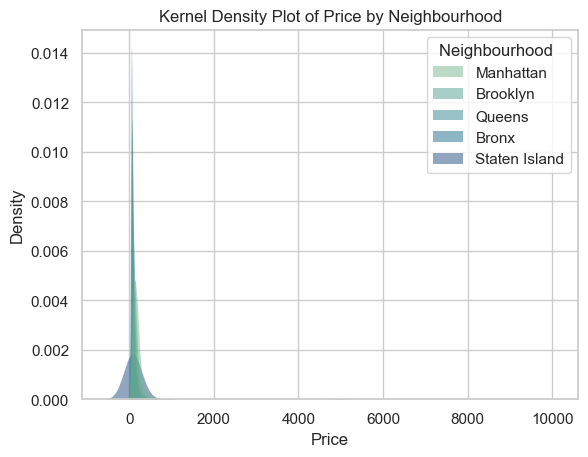

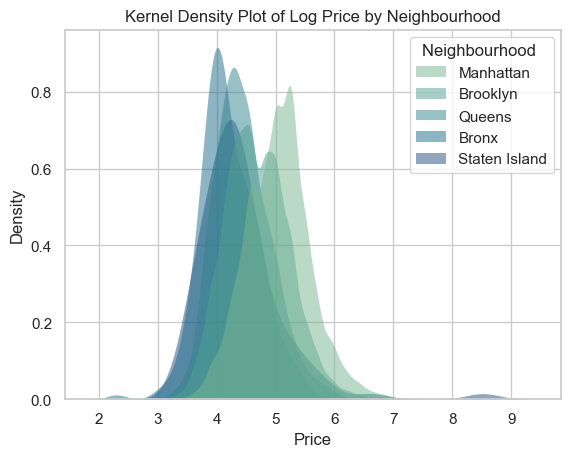

In [3]:
# compute averages for neighborhood
average_prices = df.groupby('Neighbourhood ')['Price'].mean()
average_scores = df.groupby('Neighbourhood ')['Review Scores Rating'].mean()

# find and print most expensive
most_expensive_borough = average_prices.idxmax()
print(f"The most expensive borough on average is {most_expensive_borough}")

# plot kernel density
sns.set_theme(style="whitegrid")
sns.kdeplot(data=df, x='Price', hue='Neighbourhood ', fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
plt.title('Kernel Density Plot of Price by Neighbourhood')
plt.show()

# plot log kernel density
sns.kdeplot(data=df, x=np.log(df['Price']), hue='Neighbourhood ', fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
plt.title('Kernel Density Plot of Log Price by Neighbourhood')
plt.show()

In [4]:
# part 2
import statsmodels.api as sm

# table for comparison
neighborhood_stats = df.groupby('Neighbourhood ')['Price'].agg(['mean', 'count']).round(2)

# dummy variables without intercept
dummy_neighbourhood = pd.get_dummies(df['Neighbourhood '], prefix='Neighbourhood')

# regression without intercept
X = dummy_neighbourhood
y = df['Price']
model_no_intercept = sm.OLS(y, X).fit()

# print regression results
print("Regression Results (no intercept):")
print(model_no_intercept.summary().tables[1])

# create dataframe for comparison
comparison = pd.DataFrame({
    'Mean': neighborhood_stats['mean'],
    'Coefficient': model_no_intercept.params
})
print("\nComparison of Means vs Regression Coefficients:")
print(comparison)

# print difference
print("\nDifference between regression coefficients and means:")
print((comparison['Mean'] - comparison['Coefficient']).abs().sum())

Regression Results (no intercept):
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Neighbourhood_Bronx            75.2765      9.868      7.628      0.000      55.934      94.619
Neighbourhood_Brooklyn        127.7474      1.578     80.958      0.000     124.654     130.840
Neighbourhood_Manhattan       183.6643      1.340    137.029      0.000     181.037     186.291
Neighbourhood_Queens           96.8572      3.646     26.568      0.000      89.712     104.003
Neighbourhood_Staten Island   146.1667     14.837      9.852      0.000     117.086     175.248

Comparison of Means vs Regression Coefficients:
                               Mean  Coefficient
Bronx                         75.28          NaN
Brooklyn                     127.75          NaN
Manhattan                    183.66          NaN
Neighbourhood_Bronx             NaN    75.276498

> The difference of zero shows they are the same.

In [5]:
# part 3
# table for comparison
neighborhood_stats = df.groupby('Neighbourhood ')['Price'].agg(['mean', 'count']).round(2)

# dummy variables with intercept
dummy_neighbourhood = pd.get_dummies(df['Neighbourhood '], prefix='Neighbourhood', drop_first=True)

# regression with intercept
X = sm.add_constant(dummy_neighbourhood.astype(float))
y = df['Price']
model_with_intercept = sm.OLS(y, X).fit()

# print regression results
print("Regression Results (with intercept):")
print(model_with_intercept.params.iloc[0])

# create dataframe for comparison, excluding intercept
comparison = pd.DataFrame({
    'Mean': neighborhood_stats['mean'],
    'Coefficient': model_with_intercept.params[1:]
})
print("\nComparison of Means vs Regression Coefficients (with intercept):")
print(comparison)

# print difference
print("\nDifference between regression coefficients and means (with intercept):")
print((comparison['Mean'] - comparison['Coefficient']).abs().sum())


Regression Results (with intercept):
75.2764976958536

Comparison of Means vs Regression Coefficients (with intercept):
                               Mean  Coefficient
Bronx                         75.28          NaN
Brooklyn                     127.75          NaN
Manhattan                    183.66          NaN
Neighbourhood_Brooklyn          NaN    52.470881
Neighbourhood_Manhattan         NaN   108.387789
Neighbourhood_Queens            NaN    21.580735
Neighbourhood_Staten Island     NaN    70.890169
Queens                        96.86          NaN
Staten Island                146.17          NaN

Difference between regression coefficients and means (with intercept):
0.0


> To get part two's coefficients, subtract part 3's intercept from its coefficients.

In [6]:
# part 4
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# create dummy variables
X = pd.concat([
    df['Review Scores Rating'],
    pd.get_dummies(df['Neighbourhood '], drop_first=True)
], axis=1)
y = df['Price']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions and calculate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print results
print(f"Test set R^2: {r2:.4f}")
print(f"Test set RMSE: {rmse:.2f}")
print(f"\nCoefficient for Review Scores Rating: {model.coef_[0]:.2f}")

# find most expensive neighborhood
feature_names = ['Review Scores Rating'] + list(X.columns[1:])
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.concatenate(([model.coef_[0]], model.coef_[1:] + model.intercept_))
})
print("\nNeighborhood price differences (relative to base neighborhood):")
print(coefficients[coefficients['Feature'] != 'Review Scores Rating'])

Test set R^2: 0.0459
Test set RMSE: 140.92

Coefficient for Review Scores Rating: 1.21

Neighborhood price differences (relative to base neighborhood):
         Feature  Coefficient
1       Brooklyn    16.398626
2      Manhattan    72.256209
3         Queens   -14.958771
4  Staten Island   -11.702672


In [10]:
# part 5

# create dummy variables
X = pd.concat([
    df['Review Scores Rating'],
    pd.get_dummies(df['Neighbourhood '], drop_first=True),
    pd.get_dummies(df['Property Type'], drop_first=True)
], axis=1)
y = df['Price']

# Print column names to debug
print("All column names in X:")
print(X.columns.tolist())

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions and calculate metrics
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print results
print(f"\nTest set R^2: {r2:.4f}")
print(f"Test set RMSE: {rmse:.2f}")
print(f"\nCoefficient for Review Scores Rating: {model.coef_[0]:.2f}")

# create df for coefficients
feature_names = ['Review Scores Rating'] + list(X.columns[1:])
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.concatenate(([model.coef_[0]], model.coef_[1:]))
})

# print all coefficients
print("\nAll coefficients:")
print(coefficients)

# get neighborhoods and property types, with bronx apartments as defaults
neighborhoods = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
property_types = ['Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 
                 'Castle', 'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 
                 'Lighthouse', 'Loft', 'Other', 'Townhouse', 'Treehouse', 'Villa']

# filter coefficients
neighborhood_coeffs = coefficients[coefficients['Feature'].isin(neighborhoods)]
property_coeffs = coefficients[coefficients['Feature'].isin(property_types)]

print("\nNeighborhood effects (relative to base neighborhood - Bronx):")
print(neighborhood_coeffs.sort_values('Coefficient', ascending=False))

print("\nProperty Type effects (relative to base property type - Apartment):")
print(property_coeffs.sort_values('Coefficient', ascending=False))

All column names in X:
['Review Scores Rating', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Castle', 'Chalet', 'Condominium', 'Dorm', 'House', 'Hut', 'Lighthouse', 'Loft', 'Other', 'Townhouse', 'Treehouse', 'Villa']

Test set R^2: 0.0542
Test set RMSE: 140.30

Coefficient for Review Scores Rating: 1.20

All coefficients:
                 Feature  Coefficient
0   Review Scores Rating     1.201011
1               Brooklyn    59.633702
2              Manhattan   121.005520
3                 Queens    26.830617
4          Staten Island    15.700974
5        Bed & Breakfast   -28.703920
6                   Boat    47.070419
7               Bungalow    83.972440
8                  Cabin    12.389621
9              Camper/RV   -13.817125
10                Castle   -41.810548
11                Chalet   -30.237720
12           Condominium    61.907162
13                  Dorm   -42.277758
14                 House    34.711346

> If the coefficient for `Review Scores Rating` changes between these parts, its relationship with `Price` is affected by the additional variables in the expanded model. This adjustments can lead up to believe that the effect of `Review Scores Rating` based on `Price` is not independent of these new variables.

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [11]:
# part 1
import pandas as pd

# load and show df
df = pd.read_csv('data/cars_hw.csv')
df

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000
...,...,...,...,...,...,...,...,...,...,...,...,...
971,972,Hyundai,2018,white,sedan,23869,1st,5,petrol,6-Speed,Automatic,956000
972,973,Hyundai,2019,white,sedan,14831,1st,5,petrol,6-Speed,Automatic,1027000
973,974,Hyundai,2014,silver,sedan,52846,1st,5,petrol,4-Speed,Automatic,736000
974,975,Ford,2020,white,crossover,28335,2nd,5,diesel,5-Speed,Automatic,749000


In [12]:
# clean no_of_owners
df['No_of_Owners'] = df['No_of_Owners'].str.replace('st', '').str.replace('nd', '').str.replace('rd', '').str.replace('th', '').astype(int)
df

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,515000
...,...,...,...,...,...,...,...,...,...,...,...,...
971,972,Hyundai,2018,white,sedan,23869,1,5,petrol,6-Speed,Automatic,956000
972,973,Hyundai,2019,white,sedan,14831,1,5,petrol,6-Speed,Automatic,1027000
973,974,Hyundai,2014,silver,sedan,52846,1,5,petrol,4-Speed,Automatic,736000
974,975,Ford,2020,white,crossover,28335,2,5,diesel,5-Speed,Automatic,749000


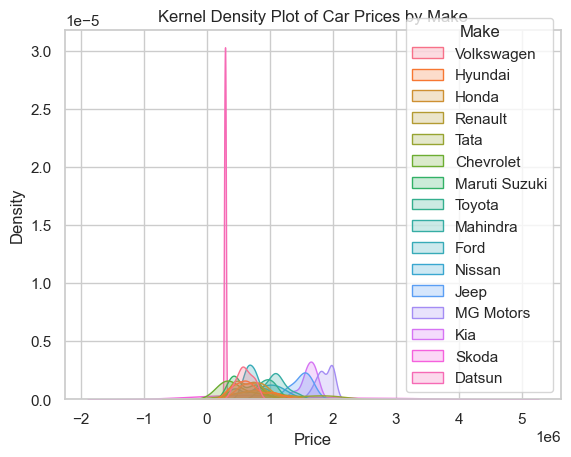

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,4.535000e+05,2.466064e+05,267000.0,288500.0,345500.0,537500.0,892000.0
Datsun,3.0,2.896667e+05,1.050397e+04,279000.0,284500.0,290000.0,295000.0,300000.0
Ford,52.0,7.211731e+05,1.409277e+05,290000.0,635000.0,707500.0,787000.0,1066000.0
Honda,73.0,7.989726e+05,2.665091e+05,316000.0,581000.0,785000.0,915000.0,1537000.0
Hyundai,305.0,6.918918e+05,2.791597e+05,248000.0,485000.0,638000.0,837000.0,1742000.0
Jeep,4.0,1.499500e+06,1.525134e+05,1290000.0,1447500.0,1529500.0,1581500.0,1649000.0
Kia,8.0,1.614750e+06,1.190567e+05,1369000.0,1579000.0,1628500.0,1705750.0,1741000.0
MG Motors,35.0,1.869457e+06,1.216611e+05,1589000.0,1786500.0,1848000.0,1978000.0,2019000.0
Mahindra,18.0,1.100167e+06,1.755493e+05,796000.0,1037000.0,1094500.0,1157000.0,1465000.0


In [13]:
# part 2
import seaborn as sns
import matplotlib.pyplot as plt

# summarize price by make
price_summary = df.groupby('Make')['Price'].describe()

# kernel density plot
sns.kdeplot(data=df, x='Price', hue='Make', fill=True, common_norm=False)
plt.title('Kernel Density Plot of Car Prices by Make')
plt.show()

# display summary
price_summary

In [14]:
# part 3
from sklearn.model_selection import train_test_split

# split the data
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
# part 4
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# numerical variables model
numeric_vars = ['Make_Year', 'Mileage_Run', 'No_of_Owners']
X_train_numeric = train[numeric_vars]
X_test_numeric = test[numeric_vars]

# fit the model
model_numeric = LinearRegression()
model_numeric.fit(X_train_numeric, train['Price'])

# predict values
y_train_pred_numeric = model_numeric.predict(X_train_numeric)
y_test_pred_numeric = model_numeric.predict(X_test_numeric)

# get r^2 values
r2_numeric_train = r2_score(train['Price'], y_train_pred_numeric)
r2_numeric_test = r2_score(test['Price'], y_test_pred_numeric)

# get rmse values
rmse_numeric_train = np.sqrt(mean_squared_error(train['Price'], y_train_pred_numeric))
rmse_numeric_test = np.sqrt(mean_squared_error(test['Price'], y_test_pred_numeric))

# repeat process for categorical variables model
categorical_vars = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission']  # Note the space after Neighbourhood
X_train_categorical = pd.get_dummies(train[categorical_vars], drop_first=True)
X_test_categorical = pd.get_dummies(test[categorical_vars], drop_first=True)

missing_cols = set(X_train_categorical.columns) - set(X_test_categorical.columns)
for col in missing_cols:
    X_test_categorical[col] = 0
X_test_categorical = X_test_categorical[X_train_categorical.columns]

model_categorical = LinearRegression()
model_categorical.fit(X_train_categorical, train['Price'])

y_train_pred_categorical = model_categorical.predict(X_train_categorical)
y_test_pred_categorical = model_categorical.predict(X_test_categorical)

r2_categorical_train = r2_score(train['Price'], y_train_pred_categorical)
r2_categorical_test = r2_score(test['Price'], y_test_pred_categorical)

rmse_categorical_train = np.sqrt(mean_squared_error(train['Price'], y_train_pred_categorical))
rmse_categorical_test = np.sqrt(mean_squared_error(test['Price'], y_test_pred_categorical))

# repeat process with a combined model
X_train_combined = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_test_combined = pd.concat([X_test_numeric, X_test_categorical], axis=1)

model_combined = LinearRegression()
model_combined.fit(X_train_combined, train['Price'])

y_train_pred_combined = model_combined.predict(X_train_combined)
y_test_pred_combined = model_combined.predict(X_test_combined)

r2_combined_train = r2_score(train['Price'], y_train_pred_combined)
r2_combined_test = r2_score(test['Price'], y_test_pred_combined)

rmse_combined_train = np.sqrt(mean_squared_error(train['Price'], y_train_pred_combined))
rmse_combined_test = np.sqrt(mean_squared_error(test['Price'], y_test_pred_combined))

# Print results
print("Numeric variables model - R^2: {:.2f}, RMSE: {:.2f}".format(r2_numeric_test, rmse_numeric_test))
print("Categorical variables model - R^2: {:.2f}, RMSE: {:.2f}".format(r2_categorical_test, rmse_categorical_test))
print("Combined model - R^2: {:.2f}, RMSE: {:.2f}".format(r2_combined_test, rmse_combined_test))

Numeric variables model - R^2: 0.30, RMSE: 284245.60
Categorical variables model - R^2: 0.69, RMSE: 187825.36
Combined model - R^2: 0.80, RMSE: 150147.72


> Based on the findings above, we see that the categorical variables are easier to predict than numeric variables. However, combining the two types into one model had the best results. Therefore, it's important to keep all variables in mind in order to maximize accuracy.

In [16]:
# part 5
from sklearn.preprocessing import PolynomialFeatures

# track r^2 and rmse values for each degree
r2_values = []
rmse_values = []

degree = 1
while True:
    # initialize with the current degree
    poly = PolynomialFeatures(degree)
    
    # fit and transform the training data to include polynomial features
    X_train_poly = poly.fit_transform(X_train_numeric)
    
    # transform the test data to include polynomial features
    X_test_poly = poly.transform(X_test_numeric)

    # initialize linear regrssion model
    model_poly = LinearRegression()
    
    # fit the model
    model_poly.fit(X_train_poly, train['Price'])

    # predict prices
    y_train_pred_poly = model_poly.predict(X_train_poly)
    y_test_pred_poly = model_poly.predict(X_test_poly)

    # calculate r^2 and rmse values
    r2_poly_train = r2_score(train['Price'], y_train_pred_poly)
    r2_poly_test = r2_score(test['Price'], y_test_pred_poly)

    rmse_poly_train = np.sqrt(mean_squared_error(train['Price'], y_train_pred_poly))
    rmse_poly_test = np.sqrt(mean_squared_error(test['Price'], y_test_pred_poly))

    # add r^2 and rmse values to their lists
    r2_values.append(r2_poly_test)
    rmse_values.append(rmse_poly_test)

    if degree < 11:
        print("Degree: {}, R^2: {:.2f}, RMSE: {:.2f}".format(degree, r2_poly_test, rmse_poly_test))
    
    degree += 1

    # check to see if r^2 is negative
    if r2_poly_test < 0:
        print(f"Degree of negative R^2: {degree}")
        break

# find best of each values
best_degree = np.argmax(r2_values) + 1
best_r2 = r2_values[best_degree - 1]
best_rmse = rmse_values[best_degree - 1]

print("Best model: Degree: {}, R^2: {:.2f}, RMSE: {:.2f}".format(best_degree, best_r2, best_rmse))


Degree: 1, R^2: 0.30, RMSE: 284245.60
Degree: 2, R^2: 0.32, RMSE: 279515.18
Degree: 3, R^2: 0.32, RMSE: 279602.95
Degree: 4, R^2: 0.32, RMSE: 279873.36
Degree: 5, R^2: 0.30, RMSE: 283018.88
Degree: 6, R^2: 0.30, RMSE: 283440.63
Degree: 7, R^2: 0.16, RMSE: 310870.38
Degree: 8, R^2: 0.15, RMSE: 312883.82
Degree: 9, R^2: 0.13, RMSE: 315225.09
Degree: 10, R^2: 0.12, RMSE: 317858.45
Degree of negative R^2: 35
Best model: Degree: 2, R^2: 0.32, RMSE: 279515.18


> As the degree increases, the $R^2$ value had a slight increase before steadily decreasing. As for RMSE, it had a slight decrease before a steady increase. As for it's comparison to part 4, it's values are very similar to those of the numerical variable model.

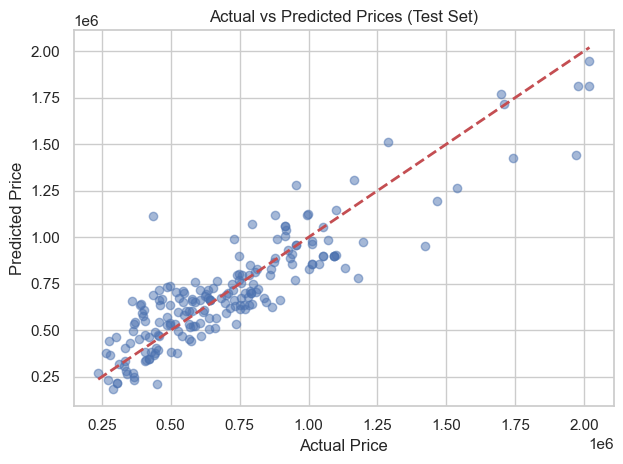

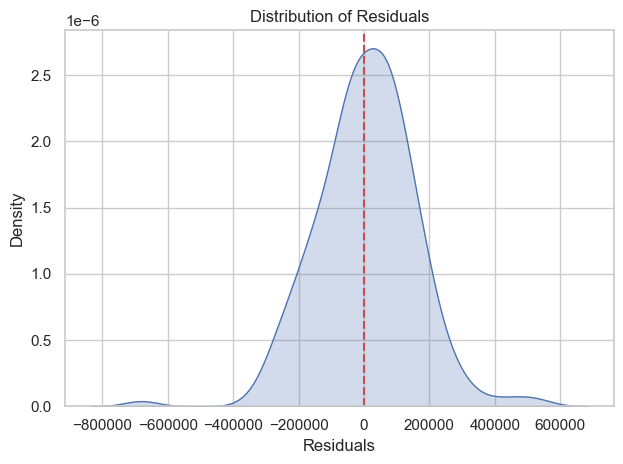

In [17]:
# part 6
import matplotlib.pyplot as plt
import seaborn as sns

# plot predicted vs actual values
plt.scatter(test['Price'], y_test_pred_combined, alpha=0.5)
plt.plot([test['Price'].min(), test['Price'].max()], [test['Price'].min(), test['Price'].max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Test Set)')
plt.tight_layout()
plt.show()

# calculate and plot residuals
residuals = test['Price'] - y_test_pred_combined
sns.kdeplot(data=residuals, fill=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

> I'd say the predicted values and true values relatively line up. There are certainly a few outliers but a correlation can be inferred from the plot, as the trend between the two is linear. As for the residuals, there is a clear bell-shape, even if it's not fully symmetric. A big strength for this model is that it's R^2 and RMSE values are extermely high compared to the other models, showing that this has good accuracy (which can be shown in these plots above). For weaknesses, there is still room for improvement to for it's accuracy around price, and there may be nonlinear relationships for other possible variables that couldn't be maintained with this model. But, given the name of the unit, it does really well for these linear relationships.

**Q4.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

In [18]:
# part 1
import pandas as pd

# load data
heart_data = pd.read_csv('data/heart_hw.csv')

# compute the survival proportion for control group
control_survival = heart_data[heart_data['transplant'] == 'control']['y'].mean()

# compute the survival proportion for treatment group
treatment_survival = heart_data[heart_data['transplant'] == 'treatment']['y'].mean()

# compute the average treatment effect
average_treatment_effect = treatment_survival - control_survival

print(f"Proportion of people who survive in the control group: {control_survival}")
print(f"Proportion of people who survive in the treatment group: {treatment_survival}")
print(f"Average treatment effect: {average_treatment_effect}")

Proportion of people who survive in the control group: 0.11764705882352941
Proportion of people who survive in the treatment group: 0.34782608695652173
Average treatment effect: 0.23017902813299232


In [19]:
# part 2
import statsmodels.api as sm

# convert transplant to numeric values
transplant_numeric = pd.get_dummies(heart_data['transplant'], drop_first=True).astype(float)

# regress y on transplant
X = sm.add_constant(transplant_numeric)
model = sm.OLS(heart_data['y'].astype(float), X).fit()

# print the constant/intercept and the coefficient on transplant
intercept = model.params.iloc[0]
coefficient =  model.params.iloc[1]
print("Constant/Intercept:", intercept)
print("Coefficient on transplant:", coefficient)

# compare constant/intercept and coefficient to the findings from part 1
print("\nComparison to part 1...")
print("- Constant/Intercept vs control survival:", intercept - control_survival)
print("- Coefficient on transplant vs average treatment effect:", coefficient - average_treatment_effect)

Constant/Intercept: 0.11764705882352913
Coefficient on transplant: 0.23017902813299246

Comparison to part 1...
- Constant/Intercept vs control survival: -2.7755575615628914e-16
- Coefficient on transplant vs average treatment effect: 1.3877787807814457e-16


> Based on these differences, they're practically the same. The difference is so miniscule that we're confident to say they're equal.

In [20]:
# part 3
# adding age to regression
X = sm.add_constant(pd.concat([transplant_numeric, heart_data['age'].astype(float)], axis=1))
model = sm.OLS(heart_data['y'].astype(float), X).fit()

# print intercept and coefficients
intercept = model.params.iloc[0]
coefficient_transplant = model.params.iloc[1]
coefficient_age = model.params.iloc[2]
print("Intercept:", intercept)
print("Coefficient on transplant:", coefficient_transplant)
print("Coefficient on age:", coefficient_age)

Intercept: 0.7019569721740962
Coefficient on transplant: 0.2647016865036752
Coefficient on age: -0.01360721716021865


> The intercept as increased by approximately 0.6.

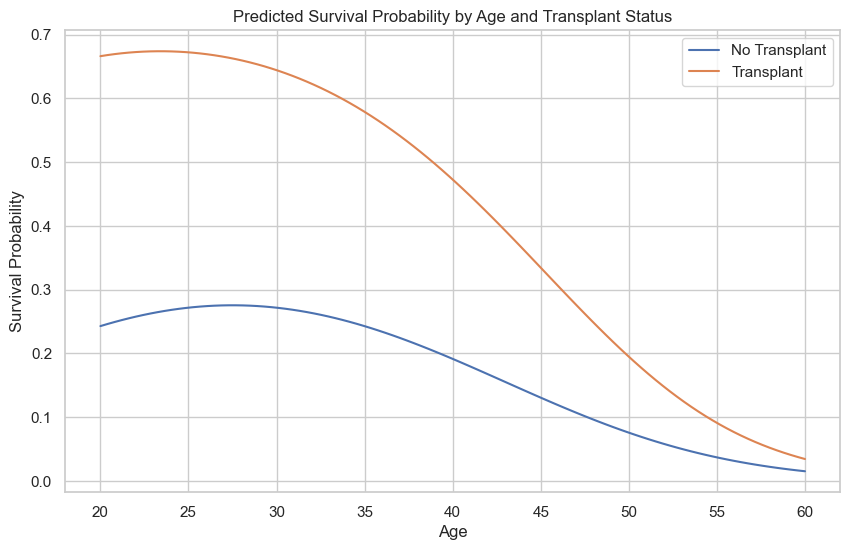

In [21]:
# part 4
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# combine age and transplant data before splitting
X = heart_data[['age']]
transplant_array = transplant_numeric.values.reshape(-1, 1)
y = heart_data['y']

# split the combined data
X_train, X_test, y_train, y_test, transplant_train, transplant_test = train_test_split(
    X, y, transplant_array, test_size=0.2, random_state=42
)

# standardize age
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# create features with standardized values
age_squared_train = X_train_scaled['age'] ** 2
age_squared_test = X_test_scaled['age'] ** 2
age_transplant_train = X_train_scaled['age'] * transplant_train.ravel()
age_transplant_test = X_test_scaled['age'] * transplant_test.ravel()

# combine features
X_train_final = np.column_stack((
    X_train_scaled, 
    age_squared_train,
    transplant_train,
    age_transplant_train
))
X_test_final = np.column_stack((
    X_test_scaled, 
    age_squared_test,
    transplant_test,
    age_transplant_test
))

# fit model
X_train_final = sm.add_constant(X_train_final)
model = sm.Logit(y_train, X_train_final).fit(method='bfgs', maxiter=1000, disp=0)


# create prediction data
ages_orig = pd.DataFrame(
    np.linspace(20, 60, 100).reshape(-1, 1),  # Reshape the numpy array first
    columns=['age']
)
ages = scaler.transform(ages_orig)
ages_squared = ages ** 2

X_pred_no_transplant = np.column_stack((
    np.ones(len(ages)),
    ages.ravel(),
    ages_squared.ravel(),
    np.zeros(len(ages)),
    np.zeros(len(ages))
))

X_pred_transplant = np.column_stack((
    np.ones(len(ages)),
    ages.ravel(),
    ages_squared.ravel(),
    np.ones(len(ages)),
    ages.ravel()
))

# predict survival probability
y_pred_no_transplant = model.predict(X_pred_no_transplant)
y_pred_transplant = model.predict(X_pred_transplant)

# plot results
plt.figure(figsize=(10, 6))
plt.plot(ages_orig, y_pred_no_transplant, label='No Transplant')
plt.plot(ages_orig, y_pred_transplant, label='Transplant')
plt.xlabel('Age')
plt.ylabel('Survival Probability')
plt.title('Predicted Survival Probability by Age and Transplant Status')
plt.legend()
plt.grid(True)
plt.show()

> For these models, I worry that there isn't enough information that is taken into account. The data to interpret is pretty precise, and there might be more than needed to examine the true probability. These individuals come from difffernt backgrounds, have different diets, live in different environments, take different medicines, etc. Accounting for more contexts only increases the true in the model. Though the current state provides the bare minimum, it's better to consider more.

**Q5.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q6.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is 
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q7.** In class, we showed that for the single linear regression model,
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

1. When will $b^*$ be large or small, depending on the relationship between $X$ and $Y$ and the variance of $X$?
2. Suppose you have measurement error in $X$ which artificially inflates its variance (e.g. bad data cleaning). We'll model this as saying the "real" value of $X$ for observation $i$ is $z_i$, but we observe $x_i = z_i + n_i$, where $n_i$ is the added noise. Does this affect the intercept of the regression? What happens to the $b^*$ coefficient relative to a noise-less model? How will affect your ability to predict? (This phenomenon is called **attenuation**.) 
3. Suppose the noise $n_i$ is independent of $z_i$ and $y_i$, so that (approximately)
$$
\dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})(n_i - \bar{n}) =0, \quad \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z})(n_i - \bar{n}) =0.
$$
and that the mean of the bias is zero, so that
$$
\dfrac{1}{N} \sum_{i=1}^N n_i = 0.
$$
In this case, the noise $n_i$ is zero on average and independent of the values of $x_i$ and $y_i$: It's just measurement error or lazy data cleaning.
Explain the intuition of your result. 

4. How does attenuation factor into the cost-benefit analysis of gathering higher quality data or cleaning it more carefully?

**Q8.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?

**Q9.** There is a folder called `heart_failure` which contains reasonably detailed health data on patients and whether they die of congestive heart failure. 

1. Load the data and perform an 80/20-train/test split.
2. Using dummy/one-hot-encoded variables and transformations of the numeric features, build the best model you can. **But**, do not delete code chunks or revise your work substantially as you experiment. Just keep moving forward with your ideas and experiments.
3. When you're done, scroll through your notebook. What worked and what didn't? Does your code have intention, or are you randomly experimenting? If you had to do this again, what might you do differently to get to a good model faster?


**Q10.** Let's look at a cousin of Linear Regression, called **kernel regression** or **local constant least squares** or **Nadaraya-Watson Estimator**.

We derived the OLS estimator for single linear regression by minimizing
$$
SSE(b_0, b_1) = \frac{1}{N}\sum_{i=1}^N (y_i - b_0 - b_1 x_i)^2
$$
with solution
$$
\hat{b}_0 = \bar{y} - \hat{b}_1 \bar{x}, \quad \hat{b}_1 = \dfrac{\frac{1}{N} \sum_{i=1}^N (x_i-\bar{x})(y_i - \bar{y})}{s_x^2}.
$$

When you step back and think about it, this is a bit weird: The algorithm is computing sample means, variances, and covariances, and using those to create a predictive model. The data themselves arguably vanish from the solution. This is elegant, this is strange.

Instead, let $k(z)$ be a kernel function, such as the Gaussian
$$
k(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}
$$
or uniform
$$
k(z) = \begin{cases}
1/2, & |z| \le \frac{1}{2}\\
0, & \text{otherwise.}
\end{cases}
$$
We'll instead minimize, or each predictor value $x$,
$$
SSE(\hat{y}(x)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(x)\right\rbrace^2 \dfrac{1}{h} k \left( \dfrac{x-x_i}{h} \right).
$$

1. Show that the optimal predictor is
$$
\hat{y}(x) = \dfrac{ \frac{1}{Nh} \sum_{i=1}^N  y_i k \left( \dfrac{x-x_i}{h} \right) }{\frac{1}{Nh} \sum_{i=1}^N k \left(  \dfrac{x-x_i}{h} \right)}
$$
This has many names, but let's call it the local constant least squares (LCLS) estimator, as opposed to ordinary least squares (OLS).

2. Compare and contrast LCLS with both OLS and $k$-Nearest Neighbor as a regression algorithm. 

3. Write a function or class that implements the LCLS estimator for a single predictor variable $x$. For a default bandwidth $h$, you can use the maximum of the Silverman plug-ins for estimating kernel densities for $X$ and $Y$:
$$
h_y = 1.06 \times s_y^{-1/5}, \quad h_x = 1.06 \times s_x^{-1/5},
$$
$$
h = \max \{ h_y, h_x \}.
$$
For the kernel, you can hard-code the uniform, Gaussian, or Epanechnikov, or make it a parameter the user can adjust with a default choice.

4. For one of the datasets available for the homework, use your LCLS estimator from part 3 to predict values $\hat{y}(x_i)$ for each datapoint $x_i$. Plot your estimator $\hat{y}$ as a line over a scatterplot of the data $\{(x_i,y_i)\}_{i=1}^N$. Tune the bandwidth until you 

5. Conceptually, how would you extend this analysis to a vector of predictors, $x = (x_1, ..., x_L)$ instead of just one explanatory variable $x$?
